<a href="https://colab.research.google.com/github/geoffcorvera/deeplearning-spring2021/blob/hw4/Grad_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

import matplotlib.pyplot as plt 

# Parameters
We load the VGG16 model (pretrained on the ImageNet dataset). The last convolutional layer in this model is named "block5_conv3" (run model.summary() to view layers of network). We define store the dimensions that input images need to be (224x224), and the path to our test files.

In [2]:
model = VGG16(weights='imagenet')
last_conv_name = 'block5_conv3'

img_size = (224,224)
img_dir = r'/content/drive/MyDrive/Spring2021/Deep Learning & Computer Vision/prog4_data'
img_path = img_dir + '/gc1.jpg'

553467904/553467096 [==============================] - 4s 0us/step


In [8]:
def preprocess_image(ipath, isize):
    # load_image returns a PIL image resized to (224,224)
    img = keras.preprocessing.image.load_img(ipath, target_size=isize)
    # convert to 3D numpy array
    im_arr = keras.preprocessing.image.img_to_array(img)
    # preprocess as per VGG16
    im_arr = preprocess_input(im_arr)
    # add dim to turn into batch of size 1
    im_arr = np.expand_dims(img, axis=0)
    return im_arr

# Display Predictions
We run model.predict() on a test image and use the decode_predictions function from the VGG16 module to display the top three predicted classes the model made.

In [41]:
def top_preds_desc(preds):
  s = f"Top {len(preds)} predictions:"
  for (i, (desc, score)) in enumerate(preds):
    s += f"\n{i+1}) {desc} (Score: {score:.4f})"
  return s

def top3_preds_desc(preds):
  decoded = decode_predictions(preds, top=3)[0]
  return [tuple(pred[1:]) for pred in decoded]

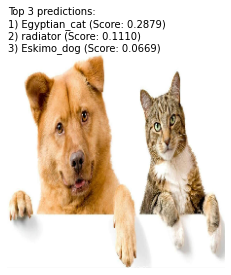

In [42]:
img = preprocess_image(img_path, img_size)

top3_preds = get_top3_predictions(model.predict(img))

plt.axis('off')
plt.text(0,0, top_preds_desc(top3_preds))
plt.imshow(img[0])
plt.show()

In [6]:
# From Stack Overflow post: https://stackoverflow.com/questions/58322147/how-to-generate-cnn-heatmaps-using-built-in-keras-in-tf2-0-tf-keras
last_layer = model.get_layer(last_conv_name)
# Create a multi-output model that maps input image to activations of the 
# last conv layer & the output predictions
heatmap_model = keras.models.Model(
    inputs=[model.inputs],
    outputs=[last_layer.output, model.output]
)

show_top = True

# Calc the gradient of the top predicted class for input image wrt last conv activations
with tf.GradientTape() as gtape:
  conv_output, predictions = heatmap_model(gc1)
  if (show_top):
    p_index = tf.argmax(predictions[0])
  else:
    p_index = tf.where(tf.equal(predictions[0], tf.constant(0.24349736)))
    p_index = p_index.numpy().squeeze()
  
  class_channel = predictions[:, p_index]

  # Gradient of top-1 prediction neuron wrt output of feature map of last conv layer
  grads = gtape.gradient(class_channel, conv_output)
  # Each element in this vector is the mean intensity of the gradient over a specific feature map channel
  importance_weights = tf.reduce_mean(grads, axis=(0,1,2))

# Calc the weighted sum of each feature map channel (weighted by importance_weights)
# wrt the top predicted class
activations = conv_output[0]
heatmap = activations @ importance_weights[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)
# Apply ReLU and scale values for display
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

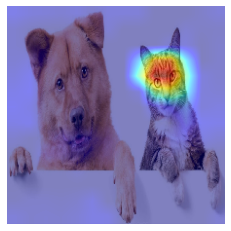

In [7]:
img = gc1.squeeze()

# Add 'batch' and 'channels' dimensions
heatmap = heatmap[tf.newaxis, ..., tf.newaxis]
heatmap = tf.image.resize(heatmap, (img.shape[0], img.shape[1])).numpy()
heatmap = heatmap.squeeze()
heatmap = np.uint8(255 * heatmap)

plt.axis('off')
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)